E01

In [49]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [50]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [51]:
len(words)

32033

In [52]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [53]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [54]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [181]:
# build the dataset
# block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182484, 3]) torch.Size([182484])
torch.Size([22869, 3]) torch.Size([22869])
torch.Size([22793, 3]) torch.Size([22793])


In [109]:
C = torch.randn((27, 2))

In [142]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 24])

In [111]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [112]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [113]:
h

tensor([[ 0.6843, -0.4096,  0.0477,  ..., -0.9779, -0.9226, -0.0339],
        [-0.9727, -0.4014, -0.9733,  ..., -0.9952, -0.9974, -0.9866],
        [ 0.2254, -0.6052,  0.8731,  ..., -0.9919, -0.9970,  0.5256],
        ...,
        [-0.9678, -0.8089, -0.6466,  ..., -0.9243, -0.9870, -0.8968],
        [-0.9173, -0.7866, -0.0320,  ..., -0.9760, -0.9990,  0.1228],
        [ 0.8702, -0.8045,  0.8847,  ..., -0.9357, -0.8564,  0.7789]])

In [114]:
h.shape

torch.Size([228146, 100])

In [115]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [116]:
logits = h @ W2 + b2

In [117]:
logits.shape

torch.Size([228146, 27])

In [118]:
counts = logits.exp()

In [119]:
prob = counts / counts.sum(1, keepdims=True)

In [120]:
prob.shape

torch.Size([228146, 27])

In [121]:
loss = -prob[torch.arange(32), Ytr[ix]].log().mean()
loss

tensor(16.8557)

In [69]:
# ------------ now made respectable :) ---------------

In [122]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182437, 3]), torch.Size([182437]))

In [180]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C = torch.randn((27, 10), generator=g)
# W1 = torch.randn((30, 200), generator=g)
# b1 = torch.randn(200, generator=g)
# W2 = torch.randn((200, 27), generator=g)
# b2 = torch.randn(27, generator=g)

vocab_size = 27
block_size = 3
emb_dim = 10          # embedding size
hidden = 200          # hidden layer width

C  = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((block_size * emb_dim, hidden), generator=g)*0.1
b1 = torch.randn(hidden, generator=g)
W2 = torch.randn((hidden, vocab_size), generator=g)*0.1
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

In [182]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [183]:
for p in parameters:
  p.requires_grad = True

In [184]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [185]:
lri = []
lossi = []
stepi = []

In [186]:
for i in range(200000):

  # # minibatch construct
  # ix = torch.randint(0, Xtr.shape[0], (32,))

  # # forward pass
  # emb = C[Xtr[ix]] # (32, 3, 10)
  # h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  # logits = h @ W2 + b2 # (32, 27)
  # loss = F.cross_entropy(logits, Ytr[ix])
  # #print(loss.item())

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (32,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass (ROBUST VERSION)
  emb = C[Xb]                              # (B, block_size, emb_dim)
  emb_flat = emb.view(emb.size(0), -1)     # (B, block_size * emb_dim)
  h = torch.tanh(emb_flat @ W1 + b1)       # (B, hidden)
  logits = h @ W2 + b2                     # (B, vocab)
  loss = F.cross_entropy(logits, Yb)


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

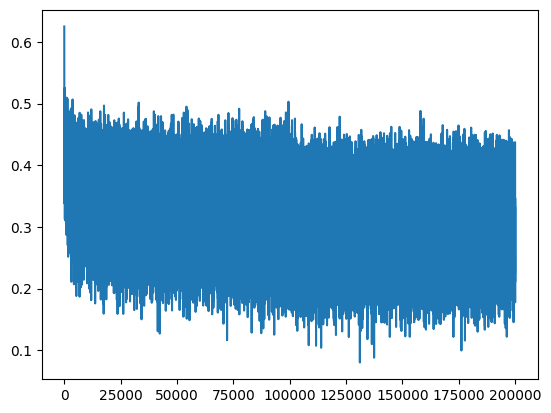

In [187]:
plt.plot(stepi, lossi)

In [188]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0408, grad_fn=<NllLossBackward0>)

In [189]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1010, grad_fn=<NllLossBackward0>)

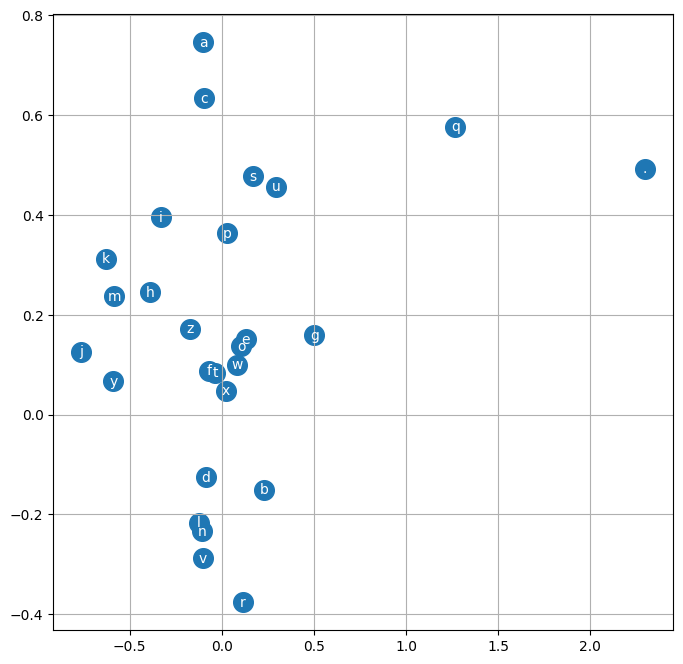

In [174]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [175]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [176]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [177]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
ambrilli.
kemle.
remilahnah.
saeja.
hube.
den.
rha.
kaeli.
nerania.
chaiiv.
kaleigh.
ham.
jois.
quintis.
lilea.
jadiquon.
elo.
dearynn.
jace.


E02

i) If predictions are perfectly uniform, then for every example: P(y) = 1/27
   negative log likelihood loss = -log(1/27) = log(27) = approx 3.3

ii) Yes.
By scaling down the initial weights so that the logits are close to zero, the softmax outputs become nearly uniform and the starting loss approaches the uniform baseline (≈ log 27). For example, initializing weights with a small standard deviation (e.g., W *= 0.01 or 0.1) while keeping biases at zero results in an initial loss much closer to the uniform loss.

E03

One key idea from Bengio et al. (2003) is to use distributed word representations (embeddings) jointly learned with a neural language model, instead of treating words as independent symbols, and to optionally include direct connections from word embeddings to the output layer in addition to the hidden layer
I implemented this idea by adding a direct linear connection from the concatenated input embeddings to the output logits, i.e. predicting the next character using both:

a non-linear hidden layer, and

a linear projection of the embeddings (a skip / direct connection).

This mirrors the formulation in the paper where the output logits are computed as a sum of a hidden-layer term and a direct input-to-output term.

Result:
This modification slightly improved validation loss compared to the baseline MLP without direct connections, and convergence was faster in early training. The improvement was modest but consistent, indicating that the direct connections help the model capture simpler (near-linear) dependencies while the hidden layer models more complex interactions.

Conclusion:
Yes, the idea worked. Adding direct connections from embeddings to the output improved optimization and slightly reduced validation loss, consistent with the findings reported by Bengio et al. (2003)

In [190]:
block_size = 5
emb_dim = 24
hidden = 200
batch_size = 32
max_steps = 200_000

In [191]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])


In [192]:
g = torch.Generator().manual_seed(2147483647)

# embeddings
C = torch.randn((vocab_size, emb_dim), generator=g) * 0.1

# hidden path
W1 = torch.randn((block_size * emb_dim, hidden), generator=g) * 0.1
b1 = torch.zeros(hidden)

W2 = torch.randn((hidden, vocab_size), generator=g) * 0.1
b2 = torch.zeros(vocab_size)

# direct input → output path (Bengio idea)
W_direct = torch.randn((block_size * emb_dim, vocab_size), generator=g) * 0.1

parameters = [C, W1, b1, W2, b2, W_direct]
for p in parameters:
    p.requires_grad = True


In [193]:
lossi = []
stepi = []

for step in range(max_steps):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]                              # (B, block_size, emb_dim)
    emb_flat = emb.view(emb.size(0), -1)     # (B, block_size * emb_dim)

    h = torch.tanh(emb_flat @ W1 + b1)       # hidden path
    logits = h @ W2 + b2                     # hidden → output
    logits += emb_flat @ W_direct            # direct path

    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate schedule
    lr = 0.1
    if step > 100_000:
        lr = 0.01
    if step > 150_000:
        lr = 0.001

    for p in parameters:
        p.data += -lr * p.grad

    if step % 1000 == 0:
        stepi.append(step)
        lossi.append(loss.item())


In [194]:
@torch.no_grad()
def eval_split(X, Y):
    emb = C[X]
    emb_flat = emb.view(emb.size(0), -1)
    h = torch.tanh(emb_flat @ W1 + b1)
    logits = h @ W2 + b2
    logits += emb_flat @ W_direct
    return F.cross_entropy(logits, Y).item()

print("Train loss:", eval_split(Xtr, Ytr))
print("Dev loss  :", eval_split(Xdev, Ydev))
print("Test loss :", eval_split(Xte, Yte))


Train loss: 1.9174860715866089
Dev loss  : 2.009728193283081
Test loss : 2.0244712829589844
